# Linear Regression Notebook
This notebook contains all the linear regression modelling and analysis done for the project. The purpose was to find the best linear regression model that best explained our outcome variable. Our outcome variable is the number of goals met, as determined by the PA Health Department for fetal mortality rate, infant mortality rate, and and percent of pre-term live births. The linear regression model will be used to inform the areas of focus and weights in the optimization portion of this project.

### Setting up and Imputations

In [1]:
## Import libraries
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
from sklearn.preprocessing import StandardScaler


In [2]:
# import cleaned, oversampled dataset
t = pd.read_csv('./data/oversample_data.csv')
feats = t[['county_name', 'population', 'pop_change_2010', 'perc_under_18',
       'perc_csec', 'perc_prenat_1tri', 'perc_non_smoke', 'fert_15_44',
       'birth_rate_15_19', 'birth_rate_20_24', 'birth_rate_25_29',
       'birth_rate_30_34', 'birth_date_35_39', 'birth_rate_40_44',
       'all_cause_death', 'chlam_per_100000', 'gono_per_100000', 'perc_smoker',
       'hiv_tested', 'perc_no_healthins', 'perc_obese', 'perc_routine_checkup',
       'beds_per_1000', 'inpatient_occupancy_rate', 'goals_met',
       'population_White', 'population_Black', 'population_Native',
       'population_Asian', 'population_NativeHawaiian_PacificIslander',
       'population_OtherRace', 'adi_staterank_mean']].drop(columns='county_name')
feats.replace({'.': None}, inplace=True)

In [3]:
# rename to match
merged = pd.concat([t[['county_name']], feats], axis=1).rename(columns={'adi_staterank_mean': 'ADI_STATERNK_INT_mean'})
merged

,county_name,population,pop_change_2010,perc_under_18,perc_csec,perc_prenat_1tri,perc_non_smoke,fert_15_44,birth_rate_15_19,birth_rate_20_24,...,beds_per_1000,inpatient_occupancy_rate,goals_met,population_White,population_Black,population_Native,population_Asian,population_NativeHawaiian_PacificIslander,population_OtherRace,ADI_STATERNK_INT_mean
0,Potter,16526.0,-5.3,20.3,35.9,77.8,78.7,68.9,27.7,145.7,...,1.5,49.2,0,0.970932,0.003416,0.001738,0.004195,0.000000,0.002997,8.222222
1,Wyoming,26794.0,-5.2,19.4,32.4,71.2,76.9,56.8,16.3,83.4,...,0.4,20.8,0,0.931014,0.018059,0.001699,0.004358,0.000000,0.003250,5.318182
2,Lehigh,369318.0,5.7,22.5,29.9,73.9,91.6,60.7,19.8,70.9,...,4.7,74.4,1,0.761519,0.072688,0.003289,0.033318,0.000305,0.060206,4.940367
3,Indiana,84073.0,-5.4,17.6,24.0,65.7,85.0,48.0,9.5,41.8,...,2.0,42.1,3,0.940838,0.022602,0.000651,0.009282,0.000166,0.004558,7.158730
4,Schuylkill,141359.0,-4.7,19.7,32.1,67.6,77.0,59.0,20.9,88.7,...,1.7,65.2,0,0.930461,0.029894,0.001649,0.004213,0.000099,0.012682,7.559322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,Susquehanna,40328.0,-7.0,18.4,31.8,64.2,78.0,61.4,19.3,95.0,...,1.2,27.6,0,0.972072,0.006108,0.000222,0.004433,0.000074,0.002832,5.628571
111,Carbon,64182.0,-1.6,19.2,29.8,74.9,79.0,56.1,17.8,84.8,...,1.7,56.9,0,0.941983,0.023388,0.002658,0.006316,0.000109,0.005300,6.583333
112,Potter,16526.0,-5.3,20.3,35.9,77.8,78.7,68.9,27.7,145.7,...,1.5,49.2,0,0.970932,0.003416,0.001738,0.004195,0.000000,0.002997,8.222222
113,Lawrence,85512.0,-6.1,19.8,30.4,70.3,76.1,61.8,20.9,83.4,...,1.1,70.1,0,0.923585,0.036147,0.000534,0.003749,0.000000,0.002380,7.186667


In [4]:
#saved parameters here -- do not rerun because random state was not saved
#merged.to_csv('parameters.csv')

In [4]:
# Creating testing and training sets
y = merged['goals_met']
X = merged.drop(columns = ['goals_met', 'county_name'])
feat_names = X.columns

In [20]:
# add imputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(X)
X = pd.DataFrame(imputer.transform(X), columns = feat_names)

In [21]:
# Set splits and seed
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
X_train.head(5)

,population,pop_change_2010,perc_under_18,perc_csec,perc_prenat_1tri,perc_non_smoke,fert_15_44,birth_rate_15_19,birth_rate_20_24,birth_rate_25_29,...,perc_routine_checkup,beds_per_1000,inpatient_occupancy_rate,population_White,population_Black,population_Native,population_Asian,population_NativeHawaiian_PacificIslander,population_OtherRace,ADI_STATERNK_INT_mean
114,26794.0,-5.2,19.4,32.4,71.2,76.9,56.8,16.3,83.4,108.6,...,89.0,0.4,20.8,0.931014,0.018059,0.001699,0.004358,0.000000,0.003250,5.318182
111,64182.0,-1.6,19.2,29.8,74.9,79.0,56.1,17.8,84.8,112.1,...,89.0,1.7,56.9,0.941983,0.023388,0.002658,0.006316,0.000109,0.005300,6.583333
101,628270.0,0.5,20.2,35.1,76.1,92.5,53.5,5.3,31.9,88.8,...,89.0,1.4,65.3,0.856975,0.038946,0.000921,0.048143,0.000257,0.020914,2.082596
46,163929.0,-3.9,19.1,33.7,79.6,83.5,58.5,15.4,69.6,108.4,...,86.0,1.7,48.2,0.897294,0.059285,0.000910,0.004606,0.000310,0.003848,6.663934
39,545724.0,5.1,23.4,27.8,61.8,93.1,69.6,13.2,82.5,126.1,...,81.0,1.5,66.7,0.875505,0.040700,0.000895,0.022994,0.000208,0.027533,4.603306


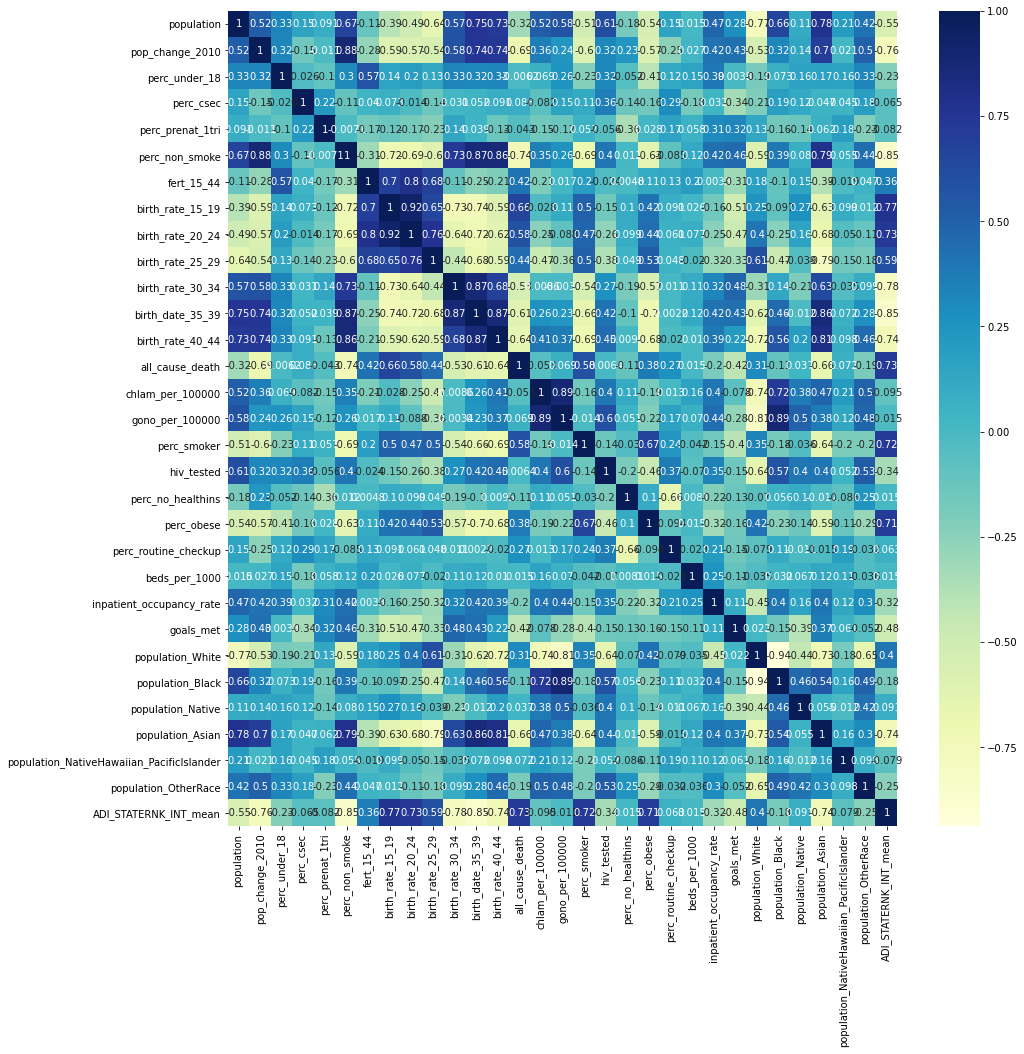

In [22]:
# plot correlation matrix
fig, ax = plt.subplots(figsize=(15,15)) 
heatmap = sns.heatmap(merged.corr(), cmap="YlGnBu", annot=True)

## Linear Regression Modelling

iteration #1: all features

In [23]:
lm = LinearRegression() #creating linear regression object
lm.fit(X_train, y_train) #fitting train data to model
print("Train R-squared: ", lm.score(X_train, y_train)) #getting train model R-squared
print("Train MSE: %.2f"% mean_squared_error(y_train, lm.predict(X_train))) #getting MSE for train data

cross_val = KFold(n_splits=10, random_state=None, shuffle=False) #creating k-fold cross validation object
score_lm = cross_val_score(lm, X_train, y_train, 
                             scoring="neg_mean_squared_error", cv=cross_val, n_jobs=-1) #getting CV scores for linear regression
lm_MSE_CV = np.abs(np.mean(score_lm)) #getting average CV error for linear regression
print("Linear Regression CV error:", lm_MSE_CV) #printing average CV error for linear regression

Train R-squared:  0.8020259740275782
Train MSE: 0.26
Linear Regression CV error: 1.7662210857211555


iteration #2: dropped less correlated variables

Train R-squared:  0.5789458671558672
Train MSE: 0.55
Linear Regression CV error: 1.7662210857211555


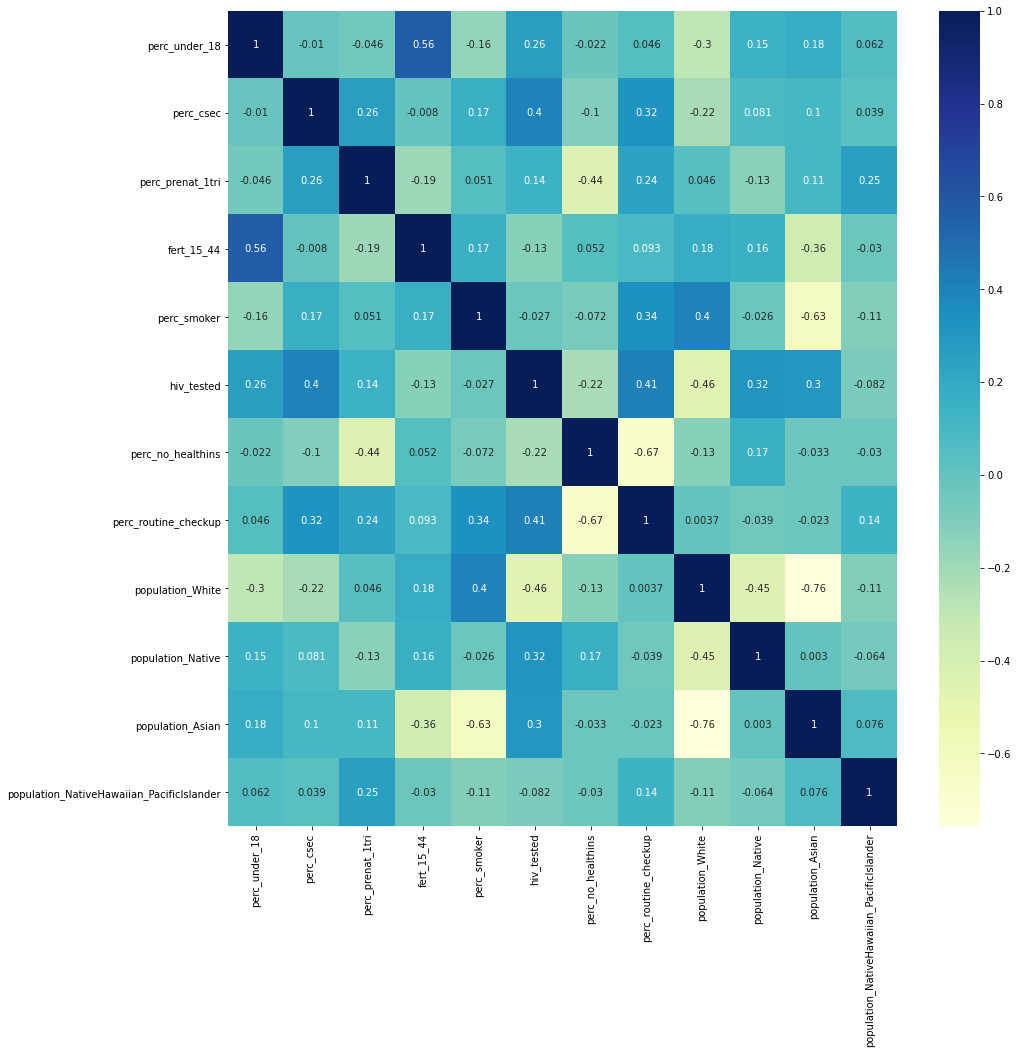

In [24]:
X_train_corr  = X_train.drop(columns =  ['population', 'perc_non_smoke', 'perc_obese', 'all_cause_death', 'population_Black', 'population_OtherRace', 'beds_per_1000', 'gono_per_100000',
                                        'birth_rate_15_19', 'birth_rate_20_24', 'birth_rate_25_29', 'birth_rate_30_34', 'birth_date_35_39', 'birth_rate_40_44',
                                        'chlam_per_100000','pop_change_2010', 'inpatient_occupancy_rate', 'ADI_STATERNK_INT_mean'])
X_test_corr  = X_test.drop(columns = ['population', 'perc_non_smoke', 'perc_obese', 'all_cause_death', 'population_Black', 'population_OtherRace', 'beds_per_1000', 'gono_per_100000', 
                                        'birth_rate_15_19', 'birth_rate_20_24', 'birth_rate_25_29', 'birth_rate_30_34', 'birth_date_35_39', 'birth_rate_40_44',
                                        'chlam_per_100000','pop_change_2010', 'inpatient_occupancy_rate', 'ADI_STATERNK_INT_mean'])

lm = LinearRegression() #creating linear regression object
lm.fit(X_train_corr, y_train) #fitting train data to model
print("Train R-squared: ", lm.score(X_train_corr, y_train)) #getting train model R-squared
print("Train MSE: %.2f"% mean_squared_error(y_train, lm.predict(X_train_corr))) #getting MSE for train data!

cross_val = KFold(n_splits=10, random_state=None, shuffle=False) #creating k-fold cross validation object
score_lm = cross_val_score(lm, X_train_corr, y_train, 
                             scoring="neg_mean_squared_error", cv=cross_val, n_jobs=-1) #getting CV scores for linear regression
lm_MSE_CV_corr = np.abs(np.mean(score_lm)) #getting average CV error for linear regression
print("Linear Regression CV error:", lm_MSE_CV) #printing average CV error for linear regression

fig, ax = plt.subplots(figsize=(15,15)) 
heatmap = sns.heatmap(X_train_corr.corr(), cmap="YlGnBu", annot=True)

iteration #3: Sequntial Feature Selection method to check # features vs. performance

In [25]:
from sklearn.feature_selection import SequentialFeatureSelector
model= LinearRegression(normalize=True) #creating model object
predictors = X_train.columns.values #saving column names of predictors
CV_scores = [] #creating empty list to score average CV errors

for i in range(1, np.shape(X_train)[1]): #looping through n-1 features
    print("Num Features:",i)
    sfs = SequentialFeatureSelector(model, 
                                    n_features_to_select = i, 
                                    direction="forward",
                                    scoring='neg_mean_squared_error',
                                    cv=10) 
    sfs = sfs.fit(X_train, y_train) #selecting i features using training data
    print("\tFeatures selected:", list(predictors[sfs.get_support()])) #getting selected features for given i
    x_subset = sfs.transform(X_train) #transforming predictors dataframe based on selected features
    CV_error = np.mean(cross_val_score(model, x_subset, y_train, cv=10, scoring='neg_mean_squared_error'))
    #getting mean cv score for linear regression fitted to training data with selected features
    CV_scores.append(CV_error) #appending average CV error to CV scores list
    print("\tCV_Error: %10.3f"%CV_error)

Num Features: 1
	Features selected: ['ADI_STATERNK_INT_mean']
	CV_Error:     -1.008
Num Features: 2
	Features selected: ['population_Native', 'ADI_STATERNK_INT_mean']
	CV_Error:     -0.844
Num Features: 3
	Features selected: ['perc_csec', 'population_Native', 'ADI_STATERNK_INT_mean']
	CV_Error:     -0.711
Num Features: 4
	Features selected: ['perc_csec', 'perc_prenat_1tri', 'population_Native', 'ADI_STATERNK_INT_mean']
	CV_Error:     -0.606
Num Features: 5
	Features selected: ['perc_csec', 'perc_prenat_1tri', 'beds_per_1000', 'population_Native', 'ADI_STATERNK_INT_mean']
	CV_Error:     -0.544
Num Features: 6
	Features selected: ['perc_csec', 'perc_prenat_1tri', 'perc_smoker', 'beds_per_1000', 'population_Native', 'ADI_STATERNK_INT_mean']
	CV_Error:     -0.517
Num Features: 7
	Features selected: ['perc_csec', 'perc_prenat_1tri', 'perc_smoker', 'perc_obese', 'beds_per_1000', 'population_Native', 'ADI_STATERNK_INT_mean']
	CV_Error:     -0.499
Num Features: 8
	Features selected: ['perc_cse

In [27]:
CV_scores =np.abs(CV_scores) #get the absolute value of the CV errors since we used negative MSE above
MSE_LR = np.min(CV_scores) #save the lowest MSE

In [28]:
# selected based on SFS
X_train_fs = X_train[['perc_csec', 'perc_prenat_1tri', 'birth_rate_15_19', 'birth_rate_20_24', 'birth_rate_25_29', 'birth_rate_30_34', 'birth_date_35_39', 'gono_per_100000',
                    'perc_smoker', 'hiv_tested', 'perc_no_healthins', 'perc_obese', 'beds_per_1000', 'population_White', 'population_Black', 'population_Native', 'population_Asian',
                    'population_OtherRace', 'ADI_STATERNK_INT_mean']]

X_test_fs = X_test[['perc_csec', 'perc_prenat_1tri', 'birth_rate_15_19', 'birth_rate_20_24', 'birth_rate_25_29', 'birth_rate_30_34', 'birth_date_35_39', 'gono_per_100000',
                    'perc_smoker', 'hiv_tested', 'perc_no_healthins', 'perc_obese', 'beds_per_1000', 'population_White', 'population_Black', 'population_Native', 'population_Asian',
                    'population_OtherRace', 'ADI_STATERNK_INT_mean']]

In [29]:
lm = LinearRegression() #creating linear regression object
lm.fit(X_train_fs, y_train) #fitting train data to model
print("Train R-squared: ", lm.score(X_train_fs, y_train)) #getting train model R-squared
print("Train MSE: %.2f"% mean_squared_error(y_train, lm.predict(X_train_fs))) #getting MSE for train data


Train R-squared:  0.7414784381110366
Train MSE: 0.34


iteration #5: add regularizers 

In [30]:
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
feature_names=X_train.columns.values #storing feature names

model_ridge = Ridge(normalize=True) #creating ridge model object
errors= [] #empty list to store errors
coef = [] #empty list to store coefficient estimates for graphing 


alphas = np.logspace(-5, 5, 300) #setting logspace range for alphas
for a in alphas: #iterating through alphas
    model_ridge.set_params(alpha=a) #setting alpha parameter for ridge model
    model_ridge.fit(X_train, y_train) #fitting model to training data
    CV_error = np.mean(cross_val_score(model_ridge, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    #getting average CV error for specific alpha using training data
    errors.append(CV_error) #storing average CV error in list
    coef.append(model_ridge.coef_) #storing coefficient estimates in list for graphing later
    
errors = np.abs(errors) #storing absolute value of errors bc we used neg MSE above
print("Min error: ", np.min(errors)) #printing min CV error
ridge_ME = np.min(errors) #storing min error for model selection later
index_ME = (np.where(errors == np.min(errors))[0]) #storing index for min CV error to get best alpha
print("Best alpha: ", alphas[index_ME]) #printing best alpha

Min error:  0.6349368761925331
Best alpha:  [0.38189133]


In [31]:
model_lasso = Lasso(normalize=True, max_iter = 100000) #creating lasso model object
errors_lasso = [] #empty list to store errors
coef_lasso = [] #empty list to store coefficient estimates for graphing 

alphas = np.logspace(-5, 5, 300) #setting logspace range for alphas
for a in alphas: #iterating through alphas
    model_lasso.set_params(alpha=a) #setting model parameter to specific alpha
    model_lasso.fit(X_train, y_train) #fitting lasso model to training data
    CV_error = np.mean(cross_val_score(model_lasso, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    #getting mean CV error using training data
    errors_lasso.append(CV_error) #appending mean CV error to list for graphing
    coef_lasso.append(model_lasso.coef_) #appending coefficient weights to list for graphing
    
errors_lasso = np.abs(errors_lasso) #getting asbolute value since negative MSE is used above
print("Min error: ", np.min(errors_lasso)) #printing min error
lasso_ME = np.min(errors_lasso) #storing min error
lasso_index_ME = (np.where(errors_lasso == np.min(errors_lasso))[0])
#storing index of min error to get best alpha
print("Best alpha: ", alphas[lasso_index_ME]) #getting best alpha using index stored in line above

Min error:  0.6266976823692951
Best alpha:  [0.00696321]


### Overall Evaluation of all linear models built

In [32]:
print('Avg CV MSE for Linear Regression: %.4f'% lm_MSE_CV)
print('Avg CV MSE for Linear Regression with Manual Feature Selection: %.4f'% lm_MSE_CV_corr)
print('Lowest SFS Linear Regression CV MSE: %.4f'% MSE_LR)
print('Lowest Ridge CV MSE with best alpha: %.4f'% ridge_ME)
print('Lowest Lasso CV MSE with best alpha: %.4f'% lasso_ME)

Avg CV MSE for Linear Regression: 1.7662
Avg CV MSE for Linear Regression with Manual Feature Selection: 0.7973
Lowest SFS Linear Regression CV MSE: 0.4552
Lowest Ridge CV MSE with best alpha: 0.6349
Lowest Lasso CV MSE with best alpha: 0.6267


In [33]:
lm = LinearRegression() #create linear reg object
lm.fit(X_train, y_train) #fitting to training data
lm_model_pred_y = lm.predict(X_test) #using fit model to predict y for test data
lm_model_test_MSE = mean_squared_error(lm_model_pred_y, y_test) #get test MSE
print("Linear Regression Test MSE:", lm_model_test_MSE)

lm = LinearRegression() #create linear reg object
lm.fit(X_train_corr, y_train) #fitting to training data
lm_model_pred_y = lm.predict(X_test_corr) #using fit model to predict y for test data
lm_corr_test_MSE = mean_squared_error(lm_model_pred_y, y_test) #get test MSE
print("Linear Regression Corr Test MSE:", lm_corr_test_MSE)

sfs = SequentialFeatureSelector(model, 
                                n_features_to_select = 13, 
                                direction="forward",
                                scoring='neg_mean_squared_error',
                                cv=10)
sfs = sfs.fit(X_train, y_train) #selecting 5 features using training data
x_subset = sfs.transform(X_train) #transforming x train data
x_subset_test = sfs.transform(X_test) #transforming x test data
lm.fit(x_subset, y_train) #fitting SFS linear model using transformed x train data
y_pred = lm.predict(x_subset_test) #predict y test using transformed x data and fitted model
sfs_MSE = mean_squared_error(y_pred, y_test) #get test MSE
print("SFS Linear Regression Test MSE:", sfs_MSE)

model_ridge.set_params(alpha=alphas[index_ME]) #set params for ridge using best alpha
y_pred = model_ridge.predict(X_test) #predict y using x test data
MSE_test_ridge = mean_squared_error(y_test, y_pred) #get test MSE
print("Ridge Regression Test MSE:", MSE_test_ridge)

model_lasso.set_params(alpha=alphas[lasso_index_ME]) #set params for ridge using best alpha
y_pred = model_lasso.predict(X_test) #predict y using x test data
MSE_test_lasso = mean_squared_error(y_test, y_pred) #get test MSE
print("Lasso Regression Test MSE:", MSE_test_lasso)

Linear Regression Test MSE: 1.379126341627188
Linear Regression Corr Test MSE: 0.5845177135832037
SFS Linear Regression Test MSE: 0.4695214676342756
Ridge Regression Test MSE: 1.1069792756323442
Lasso Regression Test MSE: 1.1070535714285714


### Selecting weights for optimization 

In [34]:
import statsmodels.api as sm
from regressors import stats
import itertools

In [39]:
lm = LinearRegression()
lm.fit(X_train_fs, y_train)

coefs = []
coefs.append(lm.intercept_)
feature_names = ['intercept']
for col in X_train_fs.columns:
    feature_names.append(col)
for coef in lm.coef_:
    coefs.append(coef)

results = pd.DataFrame(zip(feature_names, coefs, stats.coef_pval(lm, X_train_fs, y_train)), columns = ['feature', 'coefficient estimate', 'p-value'])
results

,feature,coefficient estimate,p-value
0,intercept,-22.102319,2.574005e-03
1,perc_csec,-0.139885,1.970209e-08
2,perc_prenat_1tri,0.048464,3.629119e-05
3,birth_rate_15_19,0.067832,3.451016e-02
4,birth_rate_20_24,-0.004498,2.747788e-01
5,birth_rate_25_29,-0.023740,1.387890e-04
6,birth_rate_30_34,0.047051,1.726820e-06
7,birth_date_35_39,-0.030981,1.106962e-01
8,gono_per_100000,-0.001588,3.596206e-01
9,perc_smoker,-0.026605,2.522249e-01


In [40]:
lm = LinearRegression()
lm.fit(X_train, y_train)

coefs = []
coefs.append(lm.intercept_)
feature_names = ['intercept']
for col in X_train.columns:
    feature_names.append(col)
for coef in lm.coef_:
    coefs.append(coef)

results = pd.DataFrame(zip(feature_names, coefs, stats.coef_pval(lm, X_train, y_train)), columns = ['feature', 'coefficient estimate', 'p-value'])
results

,feature,coefficient estimate,p-value
0,intercept,-4.868864e+01,7.494575e-06
1,population,8.912662e-07,5.883328e-01
2,pop_change_2010,-1.025931e-02,8.466823e-01
3,perc_under_18,-1.627635e-02,7.825185e-01
4,perc_csec,-9.197234e-02,1.936523e-04
5,perc_prenat_1tri,1.356136e-02,3.758812e-01
6,perc_non_smoke,2.522363e-01,1.491069e-08
7,fert_15_44,-3.037726e-02,5.806792e-01
8,birth_rate_15_19,1.030268e-01,1.654990e-02
9,birth_rate_20_24,-5.149796e-03,4.418762e-01


In [41]:
lm = LinearRegression()
lm.fit(X_train_corr, y_train)

coefs = []
coefs.append(lm.intercept_)
feature_names = ['intercept']
for col in X_train_corr.columns:
    feature_names.append(col)
for coef in lm.coef_:
    coefs.append(coef)

results = pd.DataFrame(zip(feature_names, coefs, stats.coef_pval(lm, X_train_corr, y_train)), columns = ['feature', 'coefficient estimate', 'p-value'])
results

,feature,coefficient estimate,p-value
0,intercept,6.892964,0.267527
1,perc_under_18,0.020708,0.722958
2,perc_csec,-0.107723,0.000210
3,perc_prenat_1tri,0.069514,0.000004
4,fert_15_44,-0.016457,0.168596
5,perc_smoker,-0.075283,0.000516
6,hiv_tested,0.025320,0.211918
7,perc_no_healthins,-0.037406,0.178544
8,perc_routine_checkup,-0.071130,0.000155
9,population_White,0.681766,0.713231
